In [54]:
import os
from bs4 import BeautifulSoup
import string
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import load_model
from keras.layers.core import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import pickle
from keras.optimizers import RMSprop
import numpy as np
from numpy import arrayimport heapq

**Import data**

In [55]:
documents = []
for file in os.listdir("sample_data/"): # original: "reuters_data/"
    if file.endswith('.sgm'): # it is important for GoogleColab
        filename = os.path.join("sample_data", file) # original: "reuters_data"
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read().lower()
        
        soup = BeautifulSoup(dataFile, 'html.parser')
        contents = soup.findAll('title')
        
        for content in contents:
            documents.append(content.text)

In [56]:
print('Number of documents: {}'.format(len(documents)))

Number of documents: 7958


In [57]:
# Remove duplicated strings from the list of strings
documents = [i for n, i in enumerate(documents) if i not in documents[:n]]

print('Number of documents: {}'.format(len(documents)))

Number of documents: 7693


In [58]:
documents[:10]

['sandoz plans weedkiller joint venture in ussr',
 'taiwan rejects textile makers exchange rate plea',
 'national fsi inc <nfsi> 4th qtr loss',
 'occidental <oxy> official resigns',
 "italy's bnl to issue 120 mln dlr convertible bond",
 'ge <ge> says amr <amr> order worth 650 mln dlrs',
 '<precambrian shield resources ltd> year loss',
 'u.k. money market given further 437 mln stg help',
 'grease monkey holding corp <gmhc> year nov 30',
 'acceptance insurance holdings inc <acpt> year']

**Join the documents**

In [59]:
data = ""
for d in documents:
    data += d

In [60]:
print('Number of data: {}'.format(len(data)))

Number of data: 347403


In [61]:
# improve punctuation
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
print('Number of data: {}'.format(len(data)))
print(data[:100])

Number of data: 346768
sandoz plans weedkiller joint venture in ussrtaiwan rejects textile makers exchange rate pleanationa


In [62]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
data = data.translate(translator)
print(data[:100])

sandoz plans weedkiller joint venture in ussrtaiwan rejects textile makers exchange rate pleanationa


In [63]:
# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded_data = tokenizer.texts_to_sequences([data])[0]
print(len(encoded_data))
encoded_data[:5]

51500


[2237, 75, 3707, 189, 440]

In [64]:
# determine the vocabulary size
# unique_words = tokenizer.word_index
unique_words = np.unique(encoded_data)
vocab_size = len(unique_words) + 1  # 0 is reserved for padding so that's why we added 1
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 14411


**Next, we need to create sequences of words to fit the model with one word as input and one word as output.**

In [65]:
# create word -> word sequences
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(1, len(encoded_data) - WORD_LENGTH):
    prev_words.append(encoded_data[i:i + WORD_LENGTH])
    next_words.append(encoded_data[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

[75, 3707, 189, 440, 3]
3708


In [66]:
print('Total Sequences: %d' % len(prev_words))

Total Sequences: 51494


In [67]:
# list(len(prev_words)[:5]) # [input, output]



**We can then split the sequences into input (X) and output elements (y)**



In [68]:
# split into X and y elements
X = prev_words
X = np.array(X)
Y = next_words
Y = np.array(Y)

# X = np.zeros((len(prev_words), WORD_LENGTH, vocab_size), dtype=bool)
# Y = np.zeros((len(next_words), vocab_size), dtype=bool)

In [69]:
print(X[:5])
print(Y[:5])

[[  75 3707  189  440    3]
 [3707  189  440    3 3708]
 [ 189  440    3 3708  264]
 [ 440    3 3708  264 1095]
 [   3 3708  264 1095 1643]]
[3708  264 1095 1643  157]


In [70]:
# one hot encode outputs
Y = to_categorical(Y, num_classes=vocab_size)
# define model
Y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [71]:
X.shape
Y.shape

(51494, 14411)

**Build the model**

In [72]:
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=1)) # original: 5
model.add(LSTM(128))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 5)              72055     
                                                                 
 lstm_2 (LSTM)               (None, 128)               68608     
                                                                 
 dense_2 (Dense)             (None, 14411)             1859019   
                                                                 
Total params: 1,999,682
Trainable params: 1,999,682
Non-trainable params: 0
_________________________________________________________________
None


**Train the model**

In [73]:
# fit network
# optimizer = RMSprop(learning_rate=0.01)

# compile network
#### since labels are INTEGERS, we need to changed from loss='categorical_crossentropy'!!!
#### If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # optimizer ='adam'
history = model.fit(X, Y, epochs=20)

## Alternative versions
# history = model.fit(X, Y, validation_split=0.05, batch_size=50, epochs=20, shuffle=True).history
# history = model.fit(X, Y, validation_split=0.05, batch_size=50, epochs=20, shuffle=True).history
# model.fit(X, Y, epochs=100)
# model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/20


1610/1610 [==============================] - 18s 10ms/step - loss: 8.3461 - accuracy: 0.0311
Epoch 2/20
1610/1610 [==============================] - 13s 8ms/step - loss: 7.7183 - accuracy: 0.0484
Epoch 3/20
1610/1610 [==============================] - 13s 8ms/step - loss: 7.3776 - accuracy: 0.0658
Epoch 4/20
1610/1610 [==============================] - 13s 8ms/step - loss: 7.0263 - accuracy: 0.0793
Epoch 5/20
1610/1610 [==============================] - 13s 8ms/step - loss: 6.6203 - accuracy: 0.0930
Epoch 6/20
1610/1610 [==============================] - 13s 8ms/step - loss: 6.1555 - accuracy: 0.1064
Epoch 7/20
1610/1610 [==============================] - 13s 8ms/step - loss: 5.6745 - accuracy: 0.1197
Epoch 8/20
1610/1610 [==============================] - 13s 8ms/step - loss: 5.2146 - accuracy: 0.1398
Epoch 9/20
1610/1610 [==============================] - 13s 8ms/step - loss: 4.7871 - accuracy: 0.1682
Epoch 10/20
1610/1610 [==============================] - 13s 8ms/step - loss: 4.388

**Save trained model**

In [74]:
# After successful training, we will save the trained model and just load it back as needed.
model.save('keras_next_word_model_lstm128_5.h5')

In [75]:
model = load_model('keras_next_word_model_lstm128_5.h5')

**Prediction**
Using saved model:
- we input the sample as a feature vector
- we convert the input string to a single feature vector

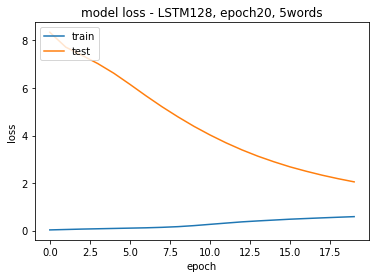

In [86]:
import matplotlib.pyplot as plt

# accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy - LSTM128, epoch20, 5words')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.savefig("accuracy.png")

# loss
plt.plot(history.history['loss'])
plt.title('model loss - LSTM128, epoch20, 5words')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.savefig("loss.png")

In [ ]:
# We use tokenizer.tokenize fo removing the punctuations and also we choose 5 first words because our predicts base on 5 previous words.

q =  "GILLETTE CANADA ISSUES 70 MLN STG BOND"

## 20 EXAMPLES FOR EVALUATION:
"""
'AMES DEPARTMENT STORE <ADD> MARCH SALES UP'
'ISRAELI HELICOPTERS RAID SOUTH LEBANON - RADIO'
'GILLETTE CANADA ISSUES 70 MLN STG BOND'
'DIGITAL COMMUNICATIONS <DCAI> SELLS SWITCHES'
'ITALIAN TREASURY BILL OFFER MEETS MIXED DEMAND'
'WESTLAND TO CUT A THIRD OF HELICOPTER WORKFORCE'
'USDA DETAILS FREE GRAIN STOCKS UNDER LOAN'
'FED SAYS U.S. DISCOUNT WINDOW BORROWINGS 361 MLN DLRS IN APRIL 8 WEEK'
'HOSPITAL CORP SAYS IT RECEIVED 47 DLR A SHARE OFFER FROM INVESTOR GROUP'
'FED SEEN BUYING DOLLARS FOR YEN IN OPEN MARKET'
'DOLLAR ENDS LOWER IN LACKLUSTRE FRANKFURT'
'HEALTH AND REHABILITATION <HRP> INITIAL PAYOUT'
'SUPERMARKETS GENERAL <SGL> FIVE WEEK SALES'
'SEKISUI CHEMICAL ISSUES EQUITY WARRANT EUROBOND'
'WEST GERMAN BEET PLANTINGS DELAYED THREE WEEKS'
'BURMAH OIL PROSPECTS REMAIN FAVOURABLE'
'PARKER DRILLING CO <PKD> 2ND QTR FEB 28 LOSS'
'TURKEY CALLS FOR DIALOGUE TO SOLVE DISPUTE'
'INVESTMENT TECHNOLOGIES <IVES> IN REBATE PACT'
'ENTOURAGE <ENTG> HAS FIRST QUARTER LOSS'
"""

print("correct sentence: ",q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

**Creating a Prediction script**

In [ ]:
from tensorflow.keras.models import load_model

# Load the model and tokenizer

model = history

def Predict_Next_Words(model, tokenizer, text):
    """
        In this function we are using the tokenizer and models trained
        and we are creating the sequence of the text entered and then
        using our model to predict and return the the predicted word.
    
    """
    for i in range(3):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = np.array(sequence)
        
        preds = model.predict_classes(sequence)
#         print(preds)
        predicted_word = ""
        
        for key, value in tokenizer.word_index.items():
            if value == preds:
                predicted_word = key
                break
        
        print(predicted_word)
        return predicted_word

In [ ]:
"""
    We are testing our model and we will run the model
    until the user decides to stop the script.
    While the script is running we try and check if 
    the prediction can be made on the text. If no
    prediction can be made we just continue.

"""

# text1 = "at the dull"
# text2 = "collection of textile"
# text3 = "what a strenuous"
# text4 = "stop the script"

while(True):

    text = input("Enter your line: ")
    
    if text == "stop the script":
        print("Ending The Program.....")
        break
    
    else:
        try:
            text = text.split(" ")
            text = text[-1]

            text = ''.join(text)
            Predict_Next_Words(model, tokenizer, text)
            
        except:
            continue